<a href="https://colab.research.google.com/github/gmb408/OSSP-KBO-prediction/blob/version-0.1/Model_Building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# 데이터 분석 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

In [ ]:
# 출력 할 때 마다, 기존 출력물들은 제거해주는 모듈
from IPython.display import clear_output

In [ ]:
# 모델 모듈
from xgboost import XGBRegressor, plot_importance
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [ ]:
result = pd.read_csv("/content/statiz_Final.csv", index_col=0)
result

,ID,이름,생일,팀,시즌,포지션,나이,G,타석,타수,...,타율_LAG3,출루_LAG3,장타_LAG3,OPS_LAG3,wOBA_LAG3,wRC+_LAG3,WAR+_LAG3,장타_NEXT,출루_NEXT,OPS_NEXT
0,0,이종범,1970-08-15,해,1994,SS,25,124.0,561.0,499.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.586,0.397,0.983
1,1,테임즈,1986-11-10,N,2015,1B,30,142.0,595.0,472.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.679,0.427,1.106
2,2,심정수,1975-05-05,현,2003,RF,29,133.0,601.0,460.0,...,0.304,0.400,0.551,0.951,0.413,149.9,5.31,NaN,NaN,NaN
3,0,이종범,1970-08-15,해,1997,SS,28,125.0,577.0,484.0,...,0.393,0.452,0.581,1.033,0.462,198.3,11.77,NaN,NaN,NaN
4,0,이종범,1970-08-15,해,1996,SS,27,113.0,525.0,449.0,...,0.280,0.331,0.432,0.762,0.350,127.4,6.14,0.581,0.428,1.009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,467,박연수,1974-01-14,L,2000,RF,27,67.0,146.0,128.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.511,0.447,0.958
1604,424,박동원,1990-04-07,넥,2016,C,27,127.0,454.0,411.0,...,0.194,0.255,0.286,0.540,0.259,0.0,0.01,0.434,0.320,0.754
1605,496,박재벌,1968-09-17,해,1996,LF,29,116.0,310.0,273.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.281,0.333,0.615
1606,547,정주현,1990-10-13,L,2018,2B,29,115.0,339.0,303.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000,0.291,0.000


In [ ]:
# 사용 features 명시
infos = ['ID','이름','생일','팀','시즌','포지션','나이']
stats = ['G','타수','득점','안타','1타','2타','3타','홈런','루타','타점','사사구','삼진','타율','출루','장타','OPS']

In [ ]:
# 누적 및 lag stat features 이름
stats_cum = [i + '_누적' for i in stats]
stats_lag1 = [i + '_LAG1' for i in stats]
stats_lag2 = [i + '_LAG2' for i in stats]
stats_lag3 = [i + '_LAG3' for i in stats]

In [ ]:
# X features와 y feature 정리
stats_position = ['2B', '3B', 'C', 'CF', 'DH', 'LF', 'RF', 'SS']
X_cols = stats + stats_cum + stats_lag1 + stats_lag2 + stats_position + ['나이'] 
y_cols = ['OPS_NEXT']
z_cols = stats + stats_cum + stats_lag1 + stats_lag2 +['나이']

resultdf = pd.DataFrame(data=result,columns=z_cols)
scaler = StandardScaler()
scaler.fit(resultdf)
results = scaler.transform(resultdf)
irisDF_scaled = pd.DataFrame(results,columns=z_cols)
result[z_cols] = irisDF_scaled[z_cols]

/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.8/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


,ID,이름,생일,팀,시즌,포지션,나이,G,타석,타수,...,wOBA_LAG3,wRC+_LAG3,WAR+_LAG3,장타_NEXT,출루_NEXT,OPS_NEXT,사사구,사사구_누적,사사구_LAG1,사사구_LAG2
0,0,이종범,1970-08-15,해,1994,SS,-1.106313,0.827252,561.0,1.456795,...,NaN,NaN,NaN,0.586,0.397,0.983,NaN,NaN,NaN,NaN
1,1,테임즈,1986-11-10,N,2015,1B,0.109482,1.582536,595.0,1.219465,...,NaN,NaN,NaN,0.679,0.427,1.106,NaN,NaN,NaN,NaN
2,2,심정수,1975-05-05,현,2003,RF,-0.133677,1.204894,601.0,1.113985,...,0.413,149.9,5.31,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,이종범,1970-08-15,해,1997,SS,-0.376836,0.869212,577.0,1.324945,...,0.462,198.3,11.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,이종범,1970-08-15,해,1996,SS,-0.619995,0.365690,525.0,1.017295,...,0.350,127.4,6.14,0.581,0.428,1.009,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1603,467,박연수,1974-01-14,L,2000,RF,-0.619995,-1.564478,146.0,-1.804295,...,NaN,NaN,NaN,0.511,0.447,0.958,NaN,NaN,NaN,NaN
1604,424,박동원,1990-04-07,넥,2016,C,-0.619995,0.953133,454.0,0.683275,...,0.259,0.0,0.01,0.434,0.320,0.754,NaN,NaN,NaN,NaN
1605,496,박재벌,1968-09-17,해,1996,LF,-0.133677,0.491571,310.0,-0.529745,...,NaN,NaN,NaN,0.281,0.333,0.615,NaN,NaN,NaN,NaN
1606,547,정주현,1990-10-13,L,2018,2B,-0.133677,0.449611,339.0,-0.266045,...,NaN,NaN,NaN,0.000,0.291,0.000,NaN,NaN,NaN,NaN


In [ ]:
df = result.fillna(-1) # nan값 -1로 impute 
df = df[df['OPS_NEXT'] > 0] # 다음 해의 OPS가 존재하는 값들만 추출 (다음 해 OPS 가 없다면, predict 값과 target값을 비교 할 수 없기 때문)
df = pd.concat([df, pd.get_dummies(df['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환


In [38]:
# 학습시킬 모델
from sklearn.ensemble import GradientBoostingRegressor
model_dict = {'xgb':XGBRegressor(objective ='reg:squarederror',n_estimators=110, learning_rate=0.05 ,max_depth=3, min_samples_split=400, random_state=23),
              'lgbm':LGBMRegressor(random_state=23),
              'rf':RandomForestRegressor(),
              'svr':SVR(),
              'knn':KNeighborsRegressor(),
              'reg':LinearRegression(),
              'ridge':Ridge(),
              'gbm' : GradientBoostingRegressor(random_state=23)
              }


In [65]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

model = model_dict['xgb']
model2 = model_dict['lgbm']
model3 = model_dict['gbm']
model4 = model_dict['xgb']
test_error = []
r2 = []

train, test = train_test_split(df, test_size=0.2, random_state=10)
y_train = train[y_cols]
y_test = test[y_cols]
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, train,test, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)

    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((train.shape[0] ,1 ))
    test_pred = np.zeros((test.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(train)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        tra, val = df.iloc[train_index], df.iloc[valid_index]
        X_train, X_test = train[X_cols],test[X_cols]
        y_train = train[y_cols]

        X_tr = train[X_cols] 
        y_tr = train[y_cols] 
        X_vl = val[X_cols]
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_vl).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean
# CV스태킹 알고리즘 각 모델에 적용

knn_train, knn_test = get_stacking_base_datasets(model,train,test, 7)
rf_train, rf_test = get_stacking_base_datasets(model2, train,test, 7)
dt_train, dt_test = get_stacking_base_datasets(model3,train,test,  7)    

# CV스태킹 알고리즘 결과로 메타 모델 학습/시험에 필요한 result_a result_b 만들기 
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test), axis=1)

# 메타 모델 학습
model4.fit(Stack_final_X_train,y_train  )
stack_final = model4.predict(Stack_final_X_test)

mse=mean_squared_error(y_test,  stack_final ,squared=False)
rmse =  np.sqrt(mse)
r2 =r2_score(y_test, stack_final)
print("test error : ", mse)
print("RMSE : ", rmse)
print("r2 : ", r2)
print("완료")

XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
	 폴드 세트:  5  시작 
	 폴드 세트:  6  시작 
GradientBoostingRegressor  model 시작 
	 폴드 세트:  0  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  1  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  2  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  3  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  4  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  5  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


	 폴드 세트:  6  시작 


/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test error :  0.13946684280053365
RMSE :  0.3734525977959367
r2 :  0.013202480943559691
완료


In [66]:
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

model = model_dict['xgb']
test_error = []
r2 = []
kf = KFold(n_splits=10, shuffle=False)
for tr,te in kf.split(df) :
    train, test = df.iloc[tr], df.iloc[te]
    X_train, X_test = train[X_cols],test[X_cols]
    y_train, y_test = train[y_cols],test[y_cols]

    model = model_dict['xgb']    #모델명 바꾸어 가면서 실험 가능
    model2 = model_dict['lgbm'] 
    model3 = model_dict['gbm']

    
    model.fit( X_train, y_train )
    model2.fit(X_train, y_train )
    model3.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    y_predict2 = model2.predict(X_test)
    y_predict3 = model3.predict(X_test)
    fin =  (y_predict  +  y_predict2 +  y_predict3)/3


    test_error.append(mean_squared_error(y_test,  fin ,squared=False) )
    r2.append(r2_score(y_test, fin ))


print("test error : ", np.mean(test_error))
print("RMSE : ", np.std(test_error))
print("r2 : ", np.mean(r2))
print("완료")
test_error

/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y =

test error :  0.10970003021454737
RMSE :  0.01290351147170938
r2 :  0.10948487087014516
완료


[0.12839291013777618,
 0.11873610905691558,
 0.11612421730268788,
 0.09158797656400375,
 0.09605335824080574,
 0.11491305247980105,
 0.1034554677764126,
 0.08905454947049887,
 0.11952558340369455,
 0.11915707771287748]

In [41]:
# 2009 ~ 2016년 기간의 데이터로 검증
# 예를들어 2010년은 2009년까지의 데이터로, 2011년은 2010년까지의 데이터로 검증
# 에러가 가장 낮은 두 모델, xgboost와 ridge 중 ridge 선택
# ridge가 xgboost에 비해 과적합이 적고 일반화가 더 잘 이뤄졌을 것이라는 판단

test_error = []
r2 = []

for year in range(2000, 2019):

    train = df[df['시즌'] < year-1].reset_index(drop=True)
    test = df[df['시즌'] == year-1].reset_index(drop=True)
    
    X_train = train[X_cols]
    y_train = train[y_cols]

    X_test = test[X_cols]
    y_test = test[y_cols]
    
    model = model_dict['xgb']    #모델명 바꾸어 가면서 실험 가능
    model2 = model_dict['lgbm'] 
    model3 = model_dict['gbm']

    
    model.fit( X_train, y_train )
    model2.fit(X_train, y_train )
    model3.fit(X_train, y_train)
    y_predict = model.predict(X_test)
    y_predict2 = model2.predict(X_test)
    y_predict3 = model3.predict(X_test)
    fin =  (y_predict*0.6)  +  (y_predict2*0.2) +  (y_predict3*0.2)

    test_error.append(mean_squared_error(y_test,  fin,squared=False) )
    r2.append(r2_score(y_test, fin))

    clear_output(wait=True)
    print(year, ": 완료")
    
print("test error : ", np.mean(test_error))
print("RMSE : ", np.std(test_error))
print("r2 : ", np.mean(r2))
print("완료")

2018 : 완료
test error :  0.1051379945946294
RMSE :  0.0168177712809371
r2 :  0.39598651704287413
완료


In [15]:
# 연도별 테스트 에러
test_error

[0.10352131856163939,
 0.09725970475292144,
 0.09580785478793834,
 0.10654044536284693,
 0.11664421565785416,
 0.08096262318756219,
 0.1400293636803558,
 0.1071082124278044,
 0.10276907007514148,
 0.11387460205482468,
 0.11406123580152883,
 0.09908202338421601,
 0.10471018267030163,
 0.08966319318703218,
 0.1528881777352559,
 0.10303774738508785,
 0.10138500547931685,
 0.09676068904941208,
 0.08401282785902722]

(0.0, 1.5)

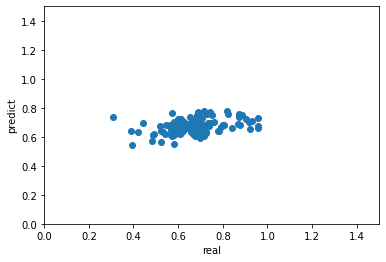

In [46]:
# 예측값과 실제값의 시각화
plt.scatter(y_test, y_predict)
plt.xlabel("real")
plt.ylabel("predict")
plt.xlim(0,1.5)
plt.ylim(0,1.5)

In [ ]:
predict = result[result['시즌']==2021] # 2022년도 데이터 프레임
predict = pd.concat([predict, pd.get_dummies(predict['포지션'], drop_first=True)], axis=1) # 포지션 dummy variable로 변환

In [ ]:
X = predict[X_cols] # 사용 feature
X = X.fillna(-1) # NA값 -1로 impute

In [ ]:
# 예측
predict['y_hat'] = model.predict(X)
new = ['이름','생일','팀','시즌','포지션','y_hat']


In [ ]:
# 타자별 예측값 feature에 저장
final = predict[new]



In [ ]:
# 제출 파일 생성
final.to_csv("/content/tnt_submission.csv", index=False, encoding='utf-8')

In [ ]:
# 제출 결과 확인
sub = pd.read_csv('/content/tnt_submission.csv')
sub

,이름,생일,팀,시즌,포지션,y_hat
0,홍창기,1993-11-21,L,2021,CF,0.812279
1,이정후,1998-08-20,키,2021,CF,0.838670
2,강백호,1999-07-29,K,2021,1B,1.000448
3,최정,1987-02-28,S,2021,3B,0.881430
4,양의지,1987-06-05,N,2021,DH,0.868420
...,...,...,...,...,...,...
187,박정현,2001-07-27,한,2021,SS,0.615148
188,이원석,1999-03-31,한,2021,CF,0.604312
189,유장혁,2000-05-30,한,2021,CF,0.610636
190,예진원,1999-03-16,키,2021,CF,0.604312
